# FE + Modeling

In [76]:
import pprint
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
# Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
# Clasification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score
# Best_searches
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Standarization
from sklearn.preprocessing import StandardScaler

from keras import models
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn import tree, ensemble, naive_bayes, neighbors, semi_supervised, discriminant_analysis, svm, linear_model, neural_network

In [77]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd
import numpy as np
import arrow
pd.set_option('display.max_columns', None)

In [78]:
df = pd.read_csv("Chess_data_basic.csv", index_col = "Unnamed: 0")

In [79]:
len(set(df["black_player_name"]+df["white_player_name"]))

4789

In [80]:
df.isna().sum()

id                     0
rated                  0
variant                0
speed                  0
createdAt              0
lastMoveAt             0
status                 0
winner               250
moves                  1
clock                  0
movesperplayer         0
white_player_name      0
white_ranking          0
black_player_name      0
black_ranking          0
dtype: int64

In [81]:
def convert_date_with_offset(date_str):
    return arrow.get(date_str).datetime

for i in ['createdAt', 'lastMoveAt']:
    df[i] = df[i].apply(convert_date_with_offset)
    
# Create Gametime column
df["Gametime"] = df["lastMoveAt"] - df["createdAt"]
# Handle Gametime column
df['Gametime'] = pd.to_timedelta(df['Gametime'])

rounding = lambda x: round(x, 1)

df['Gametime'] = df['Gametime'].dt.total_seconds().apply(rounding)
df['timepermove']=(df['Gametime']/df["movesperplayer"]).apply(rounding)

next think to do is taking insight from moves column, there is a lot of possibility but i will concentrate on:
1) Change data to perspective of one player
1) cheking for long or short castle
2) taking number of moves before castle devided by 100  ( if no castle - values set to 1 )
3) groping by opening (for this project i will take in count only first 4 moves - 2 moves per side )


## Handle NA values

In [82]:
# Only timepermove colum had NA values (just one), expect winner, where NA == DRAW
df.dropna(subset=['timepermove'],inplace=True)

df = df.fillna("draw")

df.isna().sum()

id                   0
rated                0
variant              0
speed                0
createdAt            0
lastMoveAt           0
status               0
winner               0
moves                0
clock                0
movesperplayer       0
white_player_name    0
white_ranking        0
black_player_name    0
black_ranking        0
Gametime             0
timepermove          0
dtype: int64

# Checking for side castle 

kingside castle ( short ) is O-O in moves notation and queenside castle ( long ) is O-O-O

In [83]:
def moves_column(df):
    df["moves"] = df["moves"].str.split(" ")
    df["white_moves"]=df["moves"].apply(lambda x: x[::2])
    df["black_moves"]=df["moves"].apply(lambda x: x[1::2])
    return df

df = moves_column(df)

In [84]:
def castle( df ):
    color_list = []
    my_short = []
    my_long = []
    enemy_short = []
    enemy_long = []
    
    
    for index, row in df.iterrows():
        if df["white_player_name"][index]=="EvilSaintPL":
            color_list.append(1)
        else:
            color_list.append(0)
        
        if df["white_player_name"][index]=="EvilSaintPL" and ("O-O" in df["white_moves"][index]):
            my_short.append(1)
            my_long.append(0)
        elif df["white_player_name"][index]=="EvilSaintPL" and ("O-O-O" in df["white_moves"][index]):
            my_long.append(1)
            my_short.append(0)
        elif df["black_player_name"][index]=="EvilSaintPL" and ("O-O" in df["black_moves"][index]):
            my_short.append(1)
            my_long.append(0)
        elif df["black_player_name"][index]=="EvilSaintPL" and ("O-O-O" in df["black_moves"][index]):
            my_long.append(1)
            my_short.append(0)
        else:
            my_long.append(0)
            my_short.append(0)
        
        if df["white_player_name"][index]!="EvilSaintPL" and ("O-O" in df["white_moves"][index]):
            enemy_short.append(1)
            enemy_long.append(0)
        elif df["white_player_name"][index]!="EvilSaintPL" and ("O-O-O" in df["white_moves"][index]):
            enemy_long.append(1)
            enemy_short.append(0)
        elif df["black_player_name"][index]!="EvilSaintPL" and ("O-O" in df["black_moves"][index]):
            enemy_short.append(1)
            enemy_long.append(0)
        elif df["black_player_name"][index]!="EvilSaintPL" and ("O-O-O" in df["black_moves"][index]):
            enemy_long.append(1)
            enemy_short.append(0)
        else:
            enemy_long.append(0)
            enemy_short.append(0)        
        
    df["my_kingcastle"]=my_short
    df["my_queencastle"]=my_long
    df["enemy_kingcastle"]=enemy_short
    df["enemy_queencastle"]=enemy_long
    df["my_color"]=color_list
    return df
        
df = castle(df)

In [85]:
pd.options.mode.chained_assignment = None

# num of moves before castle 

In [86]:
def find_index_of_first_occurrence(lst):
    elements = ["O-O", "O-O-O"]
    for element in elements:
        if element in lst:
            return lst.index(element)
    return len(lst) + 1

In [87]:
def moves_before_castle( df ):
    df["White_moves_before_castle"] = df["white_moves"].apply(find_index_of_first_occurrence)
    df["Black_moves_before_castle"] = df["black_moves"].apply(find_index_of_first_occurrence)
    
    my_moves_before = []
    enemy_moves_before = []
    
    for index, row in df.iterrows():
        if df["my_color"][index]==1:
            my_moves_before.append(df["White_moves_before_castle"][index])
            enemy_moves_before.append(df["Black_moves_before_castle"][index])
        else:
            my_moves_before.append(df["Black_moves_before_castle"][index])
            enemy_moves_before.append(df["White_moves_before_castle"][index])
            
    df["my_moves_before_castle"] = my_moves_before
    df["enemy_moves_before_castle"]= enemy_moves_before
    
    for index, row in df.iterrows():
        if df["my_moves_before_castle"][index]>(df["movesperplayer"][index]):
            df["my_moves_before_castle"][index]=100
        elif df["enemy_moves_before_castle"][index]>(df["movesperplayer"][index]):
            df["enemy_moves_before_castle"][index]=100
    
    df["my_moves_before_castle"] = df["my_moves_before_castle"]/(100)
    df["enemy_moves_before_castle"] = df["enemy_moves_before_castle"]/(100)
    
    return df

df=moves_before_castle( df )

## Grouping by opening

In [88]:
df["open4"] = df["moves"].apply(lambda x: x[:4])
df["open4"] = df["open4"].apply(lambda x: " ".join(x))

In [89]:
white_opens = df[df['white_player_name'] == 'EvilSaintPL']["open4"].value_counts().head(20)
black_opens = df[df['black_player_name'] == 'EvilSaintPL']["open4"].value_counts().head(20)

In [90]:
def iterable_opening_list_and_my_ranking( df ):
    
    openings_list = []
    rank_of_evilsaintpl_list = []
    evilsaintpl_won = []
    enemy_rank_list = []
    
    for index, row in df.iterrows():
        
        # OPENS1
        if df["white_player_name"][index]=="EvilSaintPL" and df["open4"][index] in white_opens.index:
            openings_list.append("White " + df["open4"][index])
        elif  df["white_player_name"][index]!="EvilSaintPL" and df["open4"][index] in black_opens.index:
            openings_list.append("Black " + df["open4"][index]) 
        else:
            openings_list.append("no opens")
        
        # MY RANK AND ENEMY RANK 
        if df["white_player_name"][index]=="EvilSaintPL":
            rank_of_evilsaintpl_list.append(df["white_ranking"][index])
            enemy_rank_list.append(df["black_ranking"][index])
        elif df["black_player_name"][index]=="EvilSaintPL":
            rank_of_evilsaintpl_list.append(df["black_ranking"][index])
            enemy_rank_list.append(df["white_ranking"][index])
        else:
            print(index)
            
        # I WON 
        if df["winner"][index] == 'draw':
            evilsaintpl_won.append(0)
        elif df["white_player_name"][index]=="EvilSaintPL" and df["winner"][index]=='white':
            evilsaintpl_won.append(1)
        elif  df["black_player_name"][index]=="EvilSaintPL" and df["winner"][index]=='black':
            evilsaintpl_won.append(1)
        else:
            evilsaintpl_won.append(-1)
            
        

    df["opens1"]= openings_list
    df["my_rank"]= rank_of_evilsaintpl_list
    df['i_won'] = evilsaintpl_won
    df['enemy_rank'] = enemy_rank_list
    
    # NEW RANKS FE
    df['rank_difference'] = df['my_rank'] - df['enemy_rank']
    df['is_higher'] = (df['my_rank'] > df['enemy_rank'])

    return df

df = iterable_opening_list_and_my_ranking(df)

In [91]:
def clear_dataframe(df):
    temp = pd.get_dummies(df["opens1"])
    df = pd.concat([df,temp], axis=1)
    
    df.drop("status",axis=1, inplace=True)
    df.drop(labels = ["opens1"], axis=1, inplace=True)
    df.drop("id",axis=1,inplace=True)
    
    df = df[df["rated"]==True]
    df = df[df["white_player_name"]!="YoungCapitan"]
    df = df[df["black_player_name"]!="YoungCapitan"]
    df.drop("variant",axis=1,inplace=True)
    
    return df

#df = clear_dataframe(df)

In [92]:
df["i_won"]=df["i_won"]+1

In [93]:
df.shape

(5363, 35)

In [94]:
df.speed.unique()

array(['blitz', 'rapid', 'classical', 'bullet'], dtype=object)

In [95]:
def rankdifftest(df):
    
    blitz = df[df["speed"]=="blitz"].reset_index(drop=True)
    classical = df[df["speed"]=="classical"].reset_index(drop=True)
    bullet = df[df["speed"]=="bullet"].reset_index(drop=True)
    rapid = df[df["speed"]=="rapid"].reset_index(drop=True)
    
    for speed in [blitz, classical, bullet, rapid]:
        rank_resu=list()
        for index, row in speed.iterrows():
            if index==0:
                rank_resu.append(speed["my_rank"][index])
            else:
                rank_resu.append(speed["my_rank"][index-1])
        speed["rank_after_game"]=rank_resu
        speed["my_rank_diff"]=speed["rank_after_game"]-speed["my_rank"]
    return pd.concat([blitz, classical, bullet, rapid])

In [96]:
df = rankdifftest(df)

In [97]:
df.head(2)

,id,rated,variant,speed,createdAt,lastMoveAt,status,winner,moves,clock,movesperplayer,white_player_name,white_ranking,black_player_name,black_ranking,Gametime,timepermove,white_moves,black_moves,my_kingcastle,my_queencastle,enemy_kingcastle,enemy_queencastle,my_color,White_moves_before_castle,Black_moves_before_castle,my_moves_before_castle,enemy_moves_before_castle,open4,opens1,my_rank,i_won,enemy_rank,rank_difference,is_higher,rank_after_game,my_rank_diff
0,O83cQxfo,True,standard,blitz,2023-06-28 02:33:43.673000+02:00,2023-06-28 02:44:00.722000+02:00,outoftime,white,"[e4, e5, Nf3, Nc6, Bc4, Nf6, d4, exd4, e5, d5,...",300,70,EvilSaintPL,1753,Leosammie,1735,617.0,8.8,"[e4, Nf3, Bc4, d4, e5, exd6, O-O, Na3, Nb5, Nb...","[e5, Nc6, Nf6, exd4, d5, Qxd6, Be7, Bg4, Qd7, ...",1,0,0,0,1,6,71,0.06,1.00,e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nc6,1753,2,1735,18,True,1753,0
1,KeBcqcHz,True,standard,blitz,2023-06-28 02:31:45.081000+02:00,2023-06-28 02:33:30.178000+02:00,resign,white,"[Nf3, Nc6, g3, e5, Bg2, e4, Ng1, d5, d3, f5, d...",300,18,convict-19,1801,EvilSaintPL,1758,105.1,5.8,"[Nf3, g3, Bg2, Ng1, d3, dxe4, Nc3, Bg5, Bxf6, ...","[Nc6, e5, e4, d5, f5, fxe4, Nf6, Be7, Bxf6, Qx...",0,1,1,0,0,17,14,0.14,0.17,Nf3 Nc6 g3 e5,no opens,1758,0,1801,-43,False,1753,-5


In [98]:
df.columns

Index(['id', 'rated', 'variant', 'speed', 'createdAt', 'lastMoveAt', 'status',
       'winner', 'moves', 'clock', 'movesperplayer', 'white_player_name',
       'white_ranking', 'black_player_name', 'black_ranking', 'Gametime',
       'timepermove', 'white_moves', 'black_moves', 'my_kingcastle',
       'my_queencastle', 'enemy_kingcastle', 'enemy_queencastle', 'my_color',
       'White_moves_before_castle', 'Black_moves_before_castle',
       'my_moves_before_castle', 'enemy_moves_before_castle', 'open4',
       'opens1', 'my_rank', 'i_won', 'enemy_rank', 'rank_difference',
       'is_higher', 'rank_after_game', 'my_rank_diff'],
      dtype='object')

In [24]:
model_columns = [ 'i_won','my_color','my_rank', 'enemy_rank','rank_difference', 'is_higher', 'movesperplayer', 'Gametime', 'timepermove','my_kingcastle', 'my_queencastle',
       'enemy_kingcastle', 'enemy_queencastle',
       'my_moves_before_castle', 'enemy_moves_before_castle', 'no opens', 'Black c4 e5 Nc3 Nf6',
       'Black d4 Nf6 Bf4 e6', 'Black d4 Nf6 Nf3 e6', 'Black d4 Nf6 c4 e6',
       'Black d4 d5 Bf4 Nf6', 'Black d4 d5 c4 c6', 'Black e4 e5 Bc4 Nc6',
       'Black e4 e5 Bc4 Nf6', 'Black e4 e5 Nc3 Nf6', 'Black e4 e5 Nf3 Nc6',
       'Black e4 e5 Nf3 Nf6', 'Black e4 e5 d4 exd4', 'Black e4 e5 f4 d5',
       'Black e4 e5 f4 exf4', 'Black e4 e6 Bc4 d5', 'Black e4 e6 Nc3 d5',
       'Black e4 e6 Nf3 d5', 'Black e4 e6 d4 d5', 'Black e4 e6 e5 c5',
       'Black g3 e5 Bg2 Nf6', 'White e4 c5 Nf3 Nc6', 'White e4 c5 Nf3 d6',
       'White e4 c5 Nf3 e6', 'White e4 c6 Nf3 d5', 'White e4 c6 d4 d5',
       'White e4 d5 Nf3 dxe4', 'White e4 d5 exd5 Nf6', 'White e4 d5 exd5 Qxd5',
       'White e4 e5 Nc3 Nc6', 'White e4 e5 Nc3 Nf6', 'White e4 e5 Nc3 d6',
       'White e4 e5 Nf3 Bc5', 'White e4 e5 Nf3 Nc6', 'White e4 e5 Nf3 Nf6',
       'White e4 e5 Nf3 Qf6', 'White e4 e5 Nf3 d5', 'White e4 e5 Nf3 d6',
       'White e4 e6 Nf3 d5', 'White e4 e6 d4 d5', 'White e4 g6 d4 Bg7'  ]

In [25]:
final_all = df[model_columns]

blitz = df[df["speed"]=="blitz"][model_columns]

classical = df[df["speed"]=="classical"][model_columns]

bullet = df[df["speed"]=="bullet"][model_columns]

rapid = df[df["speed"]=="rapid"][model_columns]

In [26]:
print(f"blitz : {blitz.shape},\nclassic: {classical.shape},\nbullet: {bullet.shape},\nrapid: {rapid.shape},\nfull: {final_all.shape}")

blitz : (3417, 56),
classic: (153, 56),
bullet: (975, 56),
rapid: (335, 56),
full: (4880, 56)


In [27]:
blitz.head(2)

,i_won,my_color,my_rank,enemy_rank,rank_difference,is_higher,movesperplayer,Gametime,timepermove,my_kingcastle,my_queencastle,enemy_kingcastle,enemy_queencastle,my_moves_before_castle,enemy_moves_before_castle,no opens,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7
0,2,1,1753,1735,18,True,70,617.0,8.8,1,0,0,0,0.06,1.00,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,0,0,1758,1801,-43,False,18,105.1,5.8,0,1,1,0,0.14,0.17,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [28]:
rapid.head(2)

,i_won,my_color,my_rank,enemy_rank,rank_difference,is_higher,movesperplayer,Gametime,timepermove,my_kingcastle,my_queencastle,enemy_kingcastle,enemy_queencastle,my_moves_before_castle,enemy_moves_before_castle,no opens,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7
0,0,1,1790,1785,5,True,62,1079.0,17.4,1,0,1,0,0.10,0.09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,2,0,1777,1783,-6,False,37,845.4,22.8,1,0,0,1,0.08,0.10,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [29]:
df.speed.unique()

array(['blitz', 'classical', 'bullet', 'rapid'], dtype=object)

In [30]:
game_modes = [blitz, classical, bullet, rapid, final_all]
game_modes_fixed = []

def fix_infinity():
    for i in game_modes:
        i = i[~i["timepermove"].isin([np.inf, -np.inf])]
        game_modes_fixed.append(i)
    return game_modes_fixed

all_fixed = fix_infinity()
blitz, classical, bullet, rapid, final_all = all_fixed

In [31]:
blitz_bullet = pd.concat([blitz,bullet])
rapid_classic = pd.concat([rapid, classical])

In [32]:
blitz_bullet

,i_won,my_color,my_rank,enemy_rank,rank_difference,is_higher,movesperplayer,Gametime,timepermove,my_kingcastle,my_queencastle,enemy_kingcastle,enemy_queencastle,my_moves_before_castle,enemy_moves_before_castle,no opens,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7
0,2,1,1753,1735,18,True,70,617.0,8.8,1,0,0,0,0.06,1.00,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,0,0,1758,1801,-43,False,18,105.1,5.8,0,1,1,0,0.14,0.17,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,0,1764,1790,-26,False,15,173.9,11.6,0,0,0,1,1.00,0.12,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,1,1771,1738,33,True,12,47.0,3.9,1,0,1,0,0.05,0.09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,0,0,1778,1760,18,True,19,180.4,9.5,1,0,1,0,0.06,0.06,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,0,0,1249,1183,66,True,27,274.7,10.2,1,0,1,0,0.11,0.06,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
971,1,1,1283,1117,166,True,52,332.3,6.4,1,0,1,0,0.09,0.06,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
972,1,0,1255,1361,-106,False,41,236.4,5.8,0,1,1,0,0.08,0.08,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
973,0,0,1347,1429,-82,False,16,66.3,4.1,1,0,1,0,0.08,0.08,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
# column definiton
"""
i_won - 0 -> I lost, 1-Draw, 2-I_Won
is_higher -> is my rank higher than my enemy
timepermove -> Gametime / movesperplayer
White_moves_before_castle -> amount of white moves before castle
no opens - no specyfic opening typed played by evilsainpl
"""

'\ni_won - 0 -> I lost, 1-Draw, 2-I_Won\nis_higher -> is my rank higher than my enemy\ntimepermove -> Gametime / movesperplayer\nWhite_moves_before_castle -> amount of white moves before castle\nno opens - no specyfic opening typed played by evilsainpl\n'

# modele

In [34]:
blitz.head()

,i_won,my_color,my_rank,enemy_rank,rank_difference,is_higher,movesperplayer,Gametime,timepermove,my_kingcastle,my_queencastle,enemy_kingcastle,enemy_queencastle,my_moves_before_castle,enemy_moves_before_castle,no opens,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7
0,2,1,1753,1735,18,True,70,617.0,8.8,1,0,0,0,0.06,1.00,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,0,0,1758,1801,-43,False,18,105.1,5.8,0,1,1,0,0.14,0.17,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,0,1764,1790,-26,False,15,173.9,11.6,0,0,0,1,1.00,0.12,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,1,1771,1738,33,True,12,47.0,3.9,1,0,1,0,0.05,0.09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,0,0,1778,1760,18,True,19,180.4,9.5,1,0,1,0,0.06,0.06,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [35]:
Train = pd.concat([blitz, bullet])
Test = pd.concat([rapid, classical])

X = Train.drop("i_won", axis=1)
y = Train["i_won"]

cols = X.columns

X_F = Test.drop(["i_won"], axis=1)
y_F = Test["i_won"]

In [36]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_F = scaler.transform(X_F)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 8)

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn import tree, ensemble, naive_bayes, neighbors, semi_supervised, discriminant_analysis, svm, linear_model, neural_network

In [38]:
def basic_models_test(X_train, X_test, y_train, y_test):
    """
    Function to test some classifiers, without any parameters
    """
    models=[
    naive_bayes.BernoulliNB(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    ensemble.ExtraTreesClassifier(),
    naive_bayes.GaussianNB(),
    semi_supervised.LabelPropagation(),
    semi_supervised.LabelSpreading(),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    svm.LinearSVC(multi_class="crammer_singer"),
    linear_model.LogisticRegression(multi_class="multinomial", max_iter=1000),
    linear_model.LogisticRegressionCV(multi_class="multinomial", max_iter=1000),
    neural_network.MLPClassifier(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ensemble.RandomForestClassifier(),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    ]
    result = dict()
    results2 = dict()
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred2 = model.predict(X_F)
        result[str(model)]= f"f1_score: {round(f1_score(y_test, y_pred, average='weighted'), 4)}, precision_score: {round(precision_score(y_test, y_pred, average='weighted'), 4)}, accuracy_score: {round(accuracy_score(y_test, y_pred), 4)}"
        results2[str(model)]=f"TEST SCORE:f1_score: {round(f1_score(y_F, y_pred2, average='weighted'), 4)}, precision_score: {round(precision_score(y_F, y_pred2, average='weighted'), 4)}, accuracy_score: {round(accuracy_score(y_F, y_pred2), 4)}"
        
        
    return result, results2
    
    

In [39]:
def model_test(model, X, y, X_test_F, y_test_F, n=5):
    """ model <- model to test,
        X, y <- X, y to train and test
        X_test. y_test <- diff data for testing only
        n <- num. of folds
    """
    Train_res = list()
    Test_res = list()
    Final_test = list()
    AVG = dict()
    
    for i in range(n):
        test_model = model
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = i)
        test_model.fit(X_train, y_train)
        y_pred_test = test_model.predict(X_test)
        y_pred_train = test_model.predict(X_train)
        Train_res.append(f1_score(y_train, y_pred_train, average='weighted'))
        Test_res.append(f1_score(y_test, y_pred_test, average='weighted'))
    test_model = model
    test_model.fit(X, y)
    y_pred_F = test_model.predict(X_test_F)
    Final_test.append(f1_score(y_test_F, y_pred_F, average='weighted'))   
        
    AVG["Train"]=sum(Train_res)/n
    AVG["Test"]=sum(Test_res)/n
    AVG["Test_Final"]=sum(Final_test)
    return AVG

In [40]:
def plot_confusion_matrix(y_true, y_pred, classes):
    """
    y_true -> true value of predicted values
    y_pred -> value estimated by model
    classes -> names of predicted classes
    """
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.arange(len(classes))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
    plt.xticks(tick_marks + 0.5, classes)
    plt.yticks(tick_marks + 0.5, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [97]:
basic_models_test(X_train, X_test, y_train, y_test)

D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\LichessData\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` 

({'BernoulliNB()': 'f1_score: 0.4722, precision_score: 0.4656, accuracy_score: 0.4923',
  'DecisionTreeClassifier()': 'f1_score: 0.4943, precision_score: 0.4945, accuracy_score: 0.4941',
  'ExtraTreeClassifier()': 'f1_score: 0.5056, precision_score: 0.5063, accuracy_score: 0.505',
  'ExtraTreesClassifier()': 'f1_score: 0.5012, precision_score: 0.5053, accuracy_score: 0.5096',
  'GaussianNB()': 'f1_score: 0.0691, precision_score: 0.5127, accuracy_score: 0.0802',
  'LabelPropagation()': 'f1_score: 0.5134, precision_score: 0.5135, accuracy_score: 0.5205',
  'LabelSpreading()': 'f1_score: 0.5083, precision_score: 0.5059, accuracy_score: 0.5169',
  'LinearDiscriminantAnalysis()': 'f1_score: 0.5454, precision_score: 0.549, accuracy_score: 0.5479',
  "LinearSVC(multi_class='crammer_singer')": 'f1_score: 0.5222, precision_score: 0.5597, accuracy_score: 0.5378',
  "LogisticRegression(max_iter=1000, multi_class='multinomial')": 'f1_score: 0.5452, precision_score: 0.5509, accuracy_score: 0.557',


In [53]:
classifiers = {
    'XGBoost': {
        'model': XGBClassifier(),
        'param_dist': {
            'max_depth': np.arange(3, 10),
            'learning_rate': [0.1, 0.01, 0.001],
            'n_estimators': [100, 200, 300, 500],
            'gamma': [0, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'param_dist': {
            'n_estimators': np.arange(100, 601, 100),
            'max_depth': np.arange(1, 71, 7),
            'min_samples_leaf': np.arange(2, 71, 7),
            'min_samples_split': np.arange(2, 71, 7),
            'max_features': ['sqrt', 'log2']
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=10000),
        'param_dist': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2', None]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_dist': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'SVM': {
        'model': SVC(),
        'param_dist': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf', 'sigmoid']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'param_dist': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2, 5, 10],
            'max_features': ['sqrt', 'log2']
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'param_dist': {
            
        }
    },
}

In [54]:
dataframes_names_str = ["blitz", "classical", "bullet", "rapid", "all_data", "blitz&bullet", "rapid&classical"]

all_dataframes = [blitz, classical, bullet, rapid, final_all, blitz_bullet, rapid_classic]

def model_for_different_gamemodes_extended():
    final_results = {}
    for dataframe, dataframe_name in zip(all_dataframes, dataframes_names_str):
        
        X = dataframe.drop("i_won", axis=1)
        y = dataframe['i_won']
        # Define the parameter grid for grid search
        
        scaler = MinMaxScaler()
        X_normalized = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, random_state = 0)  
        
        final_results[dataframe_name] = {}
        
        print(f"Dataframe: ", dataframe_name, " is on modeling!")
        
        for model_name, model_features in classifiers.items():
            
            # Initlialize a model
            model = model_features['model']
            
            param_dist = model_features['param_dist']
            

            # Create the randomized search object
            random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=5, n_iter=50, error_score='raise')

            # Perform randomized search on the training data
            random_search.fit(X_train, y_train)

            # Get the best estimator and its corresponding parameters
            best_model = random_search.best_estimator_

            # Fit the best estimator on the training data
            best_model.fit(X_train, y_train)

            # Predict on the training and test data using the best estimator
            y_pred_train = best_model.predict(X_train)
            y_pred = best_model.predict(X_test)
            
            final_results[dataframe_name][model_name] = {}

            # Calculate the evaluation metrics
            final_results[dataframe_name][model_name]["Best Estimators"] = random_search.best_params_
            final_results[dataframe_name][model_name]["Trainging Set metics"] = {}
            final_results[dataframe_name][model_name]["Trainging Set metics"]['f1_score'] = f1_score(y_train, y_pred_train, average='weighted', zero_division=1)
            final_results[dataframe_name][model_name]["Trainging Set metics"]['precision_score'] = precision_score(y_train, y_pred_train, average='weighted', zero_division=1)
            final_results[dataframe_name][model_name]["Trainging Set metics"]['accuracy_score'] = accuracy_score(y_train, y_pred_train)

            final_results[dataframe_name][model_name]["Test Set metics"] = {}
            final_results[dataframe_name][model_name]["Test Set metics"]['f1_score'] = f1_score(y_test, y_pred, average='weighted', zero_division=1)
            final_results[dataframe_name][model_name]["Test Set metics"]['precision_score'] = precision_score(y_test, y_pred, average='weighted', zero_division=1)
            final_results[dataframe_name][model_name]["Test Set metics"]['accuracy_score'] = accuracy_score(y_test, y_pred)      
    return final_results

In [55]:
final_res = model_for_different_gamemodes_extended()
pprint.pprint(final_res)

Dataframe:  blitz  is on modeling!


D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWa

Dataframe:  classical  is on modeling!


D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\li

Dataframe:  bullet  is on modeling!


D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWa

Dataframe:  rapid  is on modeling!


D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWa

Dataframe:  all_data  is on modeling!


D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWa

Dataframe:  blitz&bullet  is on modeling!


D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWa

Dataframe:  rapid&classical  is on modeling!


D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWa

{'all_data': {'Decision Tree': {'Best Estimators': {'criterion': 'gini',
                                                    'max_depth': 10,
                                                    'max_features': 'log2',
                                                    'min_samples_leaf': 10,
                                                    'min_samples_split': 10},
                                'Test Set metics': {'accuracy_score': 0.5200984413453651,
                                                    'f1_score': 0.5498026648111688,
                                                    'precision_score': 0.4996213253374663},
                                'Trainging Set metics': {'accuracy_score': 0.6057455540355677,
                                                         'f1_score': 0.5890327632863303,
                                                         'precision_score': 0.6004991748450141}},
              'KNN': {'Best Estimators': {'n_neighbors': 3,
                    

D:\LichessData\venv\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [56]:
wyniki = pd.DataFrame.from_dict(final_res)
zapis = 0
wyniki.to_json(f"finalne_wyniki_{zapis}.json")

# RandormForestClassifier

In [62]:
RF_params = final_res["blitz"]['Random Forest']["Best Estimators"]
RF = ensemble.RandomForestClassifier(**RF_params)
RF.fit(X, y)

RandomForestClassifier(max_depth=22, max_features='log2', min_samples_leaf=2,
                       min_samples_split=51, n_estimators=500)

In [72]:
model_test(RF, blitz.drop("i_won",axis=1), blitz["i_won"], rapid.drop("i_won", axis=1), rapid["i_won"], n=10)

{'Train': 0.7019042783635043,
 'Test': 0.5318077994653966,
 'Test_Final': 0.5685815362970932}

In [63]:
FE = pd.DataFrame(index = cols, data=RF.feature_importances_, columns=["ważność"])

In [64]:
FE.sort_values("ważność")

,ważność
White e4 e5 Nf3 Qf6,0.001441
Black e4 e5 Nc3 Nf6,0.001488
White e4 e5 Nf3 d5,0.001527
Black c4 e5 Nc3 Nf6,0.001655
Black g3 e5 Bg2 Nf6,0.001754
White e4 d5 Nf3 dxe4,0.001886
White e4 e6 Nf3 d5,0.002073
Black d4 Nf6 Nf3 e6,0.002624
Black e4 e5 d4 exd4,0.002701
Black e4 e5 f4 d5,0.002708


# XGBoost

In [66]:
XGB_params= final_res["blitz"]['XGBoost']["Best Estimators"]

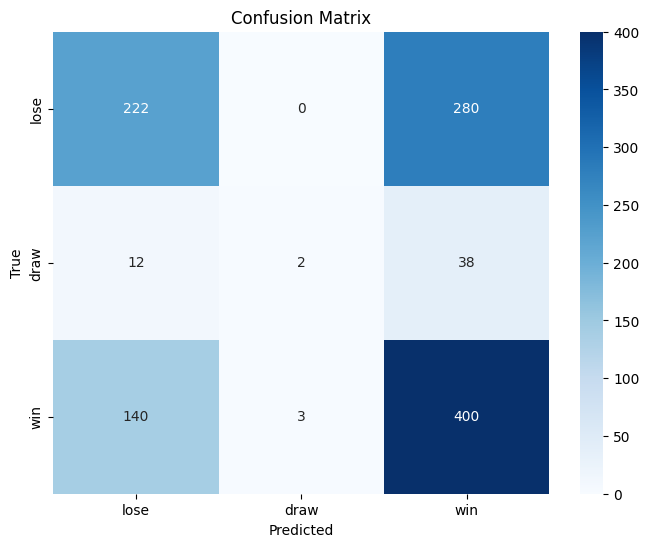

In [67]:
model_xgb = XGBClassifier(**XGB_params)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
plot_confusion_matrix(y_test, y_pred, ["lose","draw","win"])

In [68]:
model_test(model_xgb, blitz.drop("i_won",axis=1), blitz["i_won"], bullet.drop("i_won", axis=1), bullet["i_won"], n=5)

{'Train': 0.6420863238857135,
 'Test': 0.5445113433111853,
 'Test_Final': 0.5523242302925127}

# LogisticRegression

In [69]:
LogisticRegression_params = final_res["blitz"]['Logistic Regression']["Best Estimators"]
LR = linear_model.LogisticRegression(**LogisticRegression_params)
model_test(LR, blitz.drop("i_won",axis=1), blitz["i_won"], bullet.drop("i_won", axis=1), bullet["i_won"], n=10)

D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\LichessData\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

{'Train': 0.5377653389201491,
 'Test': 0.530366582713041,
 'Test_Final': 0.5570468837840703}

# Some basic NN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
Train = pd.concat([blitz, bullet])
Test = pd.concat([rapid, classical])

X = Train.drop("i_won", axis=1)
y = Train["i_won"]

X_F = Test.drop(["i_won"], axis=1)
y_F = Test["i_won"]

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# X_F = scaler.transform(X_F)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 8)
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

X_F = np.asarray(X_F).astype('float32')
y_F = np.asarray(y_F).astype('float32')


y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X.shape[1],))) # Dodaj warstwę wejściową
model.add(Dense(256, activation='relu'))  # Dodaj warstwę ukrytą
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Dodaj warstwę wyjściową z funkcją aktywacji softmax
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=110, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
NN_pred = model.predict(X_test)
NN_pred_F = model.predict(X_F)
y_pred_nn = np.argmax(NN_pred, axis=1)
y_pred_nn_F = np.argmax(NN_pred_F, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
f1_score(y_test, y_pred_nn, average='weighted')

In [ ]:
f1_score(y_F, y_pred_nn_F, average='weighted')

In [ ]:
plot_confusion_matrix(y_test, y_pred_nn, ["lose","draw","win"])

In [ ]:
plot_confusion_matrix(y_F, y_pred_nn_F, ["lose","draw","win"])

# data for visal

In [103]:
df.head(1)

,id,rated,variant,speed,createdAt,lastMoveAt,status,winner,moves,clock,movesperplayer,white_player_name,white_ranking,black_player_name,black_ranking,Gametime,timepermove,white_moves,black_moves,my_kingcastle,my_queencastle,enemy_kingcastle,enemy_queencastle,my_color,White_moves_before_castle,Black_moves_before_castle,my_moves_before_castle,enemy_moves_before_castle,open4,opens1,my_rank,i_won,enemy_rank,rank_difference,is_higher,rank_after_game,my_rank_diff
0,O83cQxfo,True,standard,blitz,2023-06-28 02:33:43.673000+02:00,2023-06-28 02:44:00.722000+02:00,outoftime,white,"[e4, e5, Nf3, Nc6, Bc4, Nf6, d4, exd4, e5, d5,...",300,70,EvilSaintPL,1753,Leosammie,1735,617.0,8.8,"[e4, Nf3, Bc4, d4, e5, exd6, O-O, Na3, Nb5, Nb...","[e5, Nc6, Nf6, exd4, d5, Qxd6, Be7, Bg4, Qd7, ...",1,0,0,0,1,6,71,0.06,1.0,e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nc6,1753,1,1735,18,True,1753,0


In [102]:
df["i_won"]=(df["i_won"]-1)

In [104]:
df["i_won"].unique()

array([ 1, -1,  0], dtype=int64)

In [105]:
df.to_csv("for_visaul3.csv")